# CA2 - ML on Agriculture in Ireland and EU

## Overview

In this notebook, ML techniques were applied on datasets related to the agriculture topic.

In the first part of the notebook, it was performed a sentiment analysis on a set of tweets collected about agriculture and food prices.

The tweets were pre-processed to extract their sentiment for two classification methods, Naive Bayes and Logistic Regression.

In the second part of this notebook, the FAO Import/Export Trade dataset was used to predict the import value and quantity of livestock and crops in Ireland and other countries.

The following models were tested in that analysis: Linear Regression and KNN Regression.

## Auxiliary Functions

In this section, the auxiliary classes and functions used in this notebook were implemented.

<b>User can skip the Twitter's Online Data Collection step to avoid accessing Twitter's API and use the previously collected dataset.</b>

The following requirements should be satisfied before running the code in this notebook:

* Instructions to perform the sentiment analysis:

    - NLTK library should be installed: The code to install this lib is commented out in the code below.


* Instructions to use the Twitter API:

    - User should have an account on <a href="https://developer.twitter.com/https://developer.twitter.com/">Twitter's Developer Portal</a> to obtain their own access keys and tokens.
    
    - The required access level to run the commands in this notebook is 'Essential'.
    
    - There should exist a file called .twitter_env in the machine's home directory with the following API user keys:

        ```
        API_KEY=***
        API_KEY_SECRET=***
        BEARER_TOKEN=***
        ```

### Imports and Constants Definition

The imports and constantes used in this project are defined in this section.

User can uncomment the commands to install any missing package.

In [1]:
# importing constants defined for this project
from constants import *

# importing modules specific to this notebook
# uncomment to install any missing lib
# !pip install wordcloud
# !pip install textblob
# !pip install punkt
# !pip install python-dotenv
# import nltk
# nltk.download()

# importing libs
from dotenv import dotenv_values
from pathlib import Path
from os import listdir
import re

import string
import logging
import warnings
import requests
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from collections import Counter
from datetime import datetime
from wordcloud import WordCloud
from textblob import TextBlob 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# ignore warnings
warnings.filterwarnings('ignore')

# use a logger to help debugging
logger = logging.getLogger('mylogger')
# set logger level
logger.setLevel(logging.ERROR)

# path to the current directory
CURR_PATH = abspath(os.getcwd())
# path to the users directory
HOME_DIR = str(Path.home())
# path to dataset dir
DATASET_DIR = join(CURR_PATH, 'datasets')
# path to store collected tweets
TWEETS_DIR = join(DATASET_DIR, 'tweets_online')

# twitter csv data file
TWITTER_DF_FILE = 'tweets_df'

# twitter env file
TWITTER_ENV_FILE = '.twitter_env'

# list of sentiment labels
sentiment_lst = ['negative', 'neutral', 'positive']

### Auxiliary Classes

The classes below were implemented to process the Twitter's requests, JSON files and to apply text processing.

The idea was to modulatize the code, keeping each function to its own class when applicable, which improves code readability, maintainability and reuse.

### Auxiliary Functions

In this section, the auxiliary functions were implemented to help modularize the code analysis.

In [20]:
def get_collected_twitter_file_path():
    """
    Auxiliary function to get a valid twitter file name.
    
    It checks if there is a file with the same name and append an index.

    Returns:
        filename (str): Available filename.
    """    
    same_file_list = [f for f in listdir(TWEETS_DIR) if isfile(join(TWEETS_DIR, f)) 
                      and str(f).startswith(TWITTER_DF_FILE) and str(f).endswith('.csv')]
    n_same_file = len(same_file_list)

    suffix = ''
    if n_same_file > 0:
        suffix = f'_{ n_same_file }'

    filename = f'{TWITTER_DF_FILE}{ suffix }.csv'
    return join(TWEETS_DIR, filename)

def get_env_map():
    """
    Auxiliary function to read and parse the environment file for the Twitter API.
    
    It assumes an env file exists in the home dir.

    Returns:
        env (dict): Dictionary with the env parameters.
    """
    env_path = join(HOME_DIR, TWITTER_ENV_FILE)

    if not os.path.exists(env_path):
        logger.error(F'Unable to read the environment file. Make sure a { TWITTER_ENV_FILE } file exists in your home directory.')
        return None

    return dotenv_values(env_path)

def process_tweets(tweets_list):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for i in range(0, len(tweets_list)):
        # raw tweet
        tweet_raw = tweets_list[i]
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        # strip tweet
        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)
        
        # cleaned tweet
        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        # steemed tweet
        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        # lemmatized tweet
        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def get_freq(df, colname):
    """
    Auxiliary function to calculate the frequency distribution of the words in a column.

    Parameters:
        df (DataFrame): Data frame to be processed.
        colname  (str): Column name to get its frequency calculated.
    Returns:
        fdist    (mtx): Frequency distribution of the tokens.
    """
    tokens_lst = []
    for i in range(0, len(df)):
        text = df.loc[i][colname]
        tokens_lst+= TextProcessor.get_tokens(text)

    fdist = FreqDist(tokens_lst)

    return fdist

def wordcloud_draw(data, color='black'):
    """
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    """
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def is_valid_vectorizer(obj):
    """
    Auxiliary function to validate the vectorizer object.

    Parameters:
        obj (obj): Instance of a vectorizer to be validated.
    Returns:
        True if valid, False otherwise.
    """    
    if isinstance(obj, TfidfVectorizer):
        return True
    if isinstance(obj, CountVectorizer):
        return True
    return False
    
def run_text_vectorizer(df, x_name, vec_inst, max_f=5000):
    """
    Auxiliary function to run the text vectorizer passed in the input.

    Parameters:
        df (DataFrame): Data frame to be processed.
        x_name   (str): Name of the column to be processed.
        vec_inst (obj): Text vectorizer instance to be used.
    Returns:
        x_vec    (arr): Feature vector extracted from each text in the processed column.
    """
    if not is_valid_vectorizer(vec_inst):
        raise Exception(f'Not a valid vectorizer! { type(vec_inst) }')

    # getting feat vectors for x_name
    x_vec = vec_inst.fit_transform(df[x_name]).toarray()

    logger.info(f'Feature vector using { type(vec_inst) }: { x_vec.shape }')

    return x_vec

def resample(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res
    
def get_X_y(df, x_name, y_name, vec_inst=None):
    """
    Auxiliary function to return X, y data to be processed by the classifier.

    Parameters:
        df (DataFrame): Data frame to be processed.
        x_name   (str): Name of the column to be processed as independent variable.
        y_name   (str): Name of the column to be processed as target.
        vec_inst (obj): Text vectorizer instance to be used in the x column data.
    Returns:
        X, y     ((Series, Series)): X, y data series.
    """
    # remove duplicates from x
    df = df.drop_duplicates(subset=[x_name])

    X = df[x_name]
    if vec_inst is not None:        
        # extracting tokens from column using input function
        X = run_text_vectorizer(df, x_name, vec_inst)

    # getting target data
    y = df[y_name]

    # convert target data into numbers
    y = y.apply(lambda x: sentiment_lst.index(x))

    return X, y

def run_naive_bayes_classifier_cross_val(X, y, cv=5):
    """
    Auxiliary function to run Naive Bayes classifier using cross validation.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
        cv   (int): Number of folds to be used by cross validation function.
    Returns:
        cv_res (dict): Results of the cross validation score method.
    """      
    model = MultinomialNB()    
    cv_res = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    return cv_res
    
def run_naive_bayes_classifier(X, y):
    """
    Auxiliary function to run Naive Bayes classifier.

    Parameters:
        X (Series): X variable data.
        y (Series): y Target variable data.
    Returns:
        cf (dict): Results of the classifier.
    """     
    # instantiate a naive bayes model classifer
    model = MultinomialNB()
    
    # split the dataset into training and testing parts
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # train the model by calling a method fit()
    model.fit(X_train, y_train)
    
    # predict test data using the model
    y_pred = model.predict(X_test)
    
    # getting classification report from the model
    cf = classification_report(y_test, y_pred, target_names=sentiment_lst)

    return cf

## Sentiment Analysis

In this section, the Twitter API was used to retrieve recent tweets for the sentiment analysis.

The purpose of this search were to find tweets about inflation or food price, which relate to the agriculture topic.

The limitation of this search is that the subject of the tweets is not necessarily relevant to the agriculture topic.

### Twitter's Online Data Collection

Twitter's API were used to collect recent tweets on the agriculture topic.

The tags used for this search were inflation, food price and agriculture in an attempt to get relevant tweets.

This section can be skipped, in that case, the previously collected data will be used in the next sections.

In [4]:
# twitter api instance
twitter_api = TwitterApi(get_env_map())

# retrieving tweets according to the query
query_params = {
    'query' : '(inflation OR "food price" OR "agriculture") Europe -is:retweet -has:media lang:en',
    'tweet.fields': 'author_id', 
    'user.fields': 'name',
    'max_results': '100'
}
tweets_list = twitter_api.search_tweets(query_params)

# processing retrieved data using text processing
tweets_df = process_tweets(tweets_list)

# persisting processed dataset
tweets_df.to_csv(get_collected_twitter_file_path())
tweets_df.head()

199 tweets retrieved!


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,@zoltanspox @Szazadveg Zoli: the high inflatio...,positive,zoli the high inflation in hungary is self ...,positive,zoli high inflation hungary self made fidesz h...,positive,zoli high inflat hungari self made fidesz high...,positive,zoli high inflation hungary self made fidesz h...,positive
1,What is the bear case USD? We settle at 3-4% p...,negative,what is the bear case usd we settle at p...,negative,bear case usd settle pce without recession chi...,negative,bear case usd settl pce without recess china e...,negative,bear case usd settle pce without recession chi...,negative
2,"@DonaldTrumpNyet Economy is cratering, borders...",negative,economy is cratering borders broken open in...,negative,economy cratering borders broken open inflatio...,negative,economi crater border broken open inflat surg ...,negative,economy cratering borders broken open inflatio...,negative
3,"When does the crisis strike?\nwell, it cannot ...",positive,when does the crisis strike well it cannot b...,positive,crisis strike well predicted would venture mar...,positive,crisi strike well predict would ventur march a...,neutral,crisis strike well predicted would venture mar...,positive
4,Bulgaria's 🇧🇬 housing market is still going st...,positive,bulgaria s housing market is still going st...,positive,bulgaria housing market still going strong inf...,positive,bulgaria hous market still go strong inflat cr...,positive,bulgaria housing market still going strong inf...,positive


### Data Preparation and Visualization

The twitter's dataset was created using the above Twitter API code. The raw tweets were preserved in the tweet_raw column and new columns were created with the processed data.

The tweet_str column stores the tweets after the clean step only, which removes special characters.

The tweet_clr column stores the tweets after the clean step and removal of stop words.

The columns called tweet_st and tweet_lm refer to the tweet text after applying Porter Stemmer and Lemmatizer strategies, respectively on the cleaned tweet.

Each version of the tweet (i.e., tweet_str, tweet_clr, tweet_st and tweet_lm) has its own sentiment calculated, because it was observed that the sentiment algorithm provides different results for each of them. The possible sentiments are: positive, negative and neutral.

This way, the sentiment analysis can be performed on each version of the tweet + sentiment class.

In [5]:
# skip this step if you've run the previous step
tweets_df = pd.read_csv('./datasets/agri_tweets.csv')
tweets_df.head()

,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
0,British public were treated like mugs..lied to...,negative,british public treated like mugs lied sold riv...,neutral,british public treat like mug lie sold river p...,positive,british public treated like mugs lied sold riv...,positive,british public were treated like mugs lied to...,negative
1,EU economies set to contract in 2023 - Financi...,positive,eu economies set contract financial times acco...,positive,eu economi set contract financi time accord ex...,positive,eu economies set contract financial times acco...,positive,eu economies set to contract in financi...,positive
2,Big big good news for all #Europe and #USA in ...,negative,big big good news europe usa cold season natur...,positive,big big good news europ usa cold season natura...,positive,big big good news europe usa cold season natur...,positive,big big good news for all europe and usa in su...,negative
3,"""The measures, coupled with an agreement negot...",positive,measures coupled agreement negotiated european...,positive,measur coupl agreement negoti european union p...,negative,measures coupled agreement negotiated european...,positive,the measures coupled with an agreement negot...,positive
4,It was due to the problems of Europe (Covid-19...,positive,due problems europe covid russia ukraine war r...,positive,due problem europ covid russia ukrain war rece...,positive,due problems europe covid russia ukraine war r...,positive,it was due to the problems of europe covid ...,positive


It was observed that after applying the text processing on the tweets, duplicates were generated. For example, tweet_clr has 171 distinct rows from 200.

That will be handled when applying the ML models in the experiments.

In [6]:
# investigating the characteristics of the dataset
tweets_df.describe()

,tweet_raw,sent_raw,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm,tweet_str,sent_str
count,200,200,200,200,200,200,200,200,200,200
unique,200,3,171,3,171,3,171,3,178,3
top,British public were treated like mugs..lied to...,positive,inflation baltics warning rest europe,positive,inflat baltic warn rest europ,neutral,inflation baltics warning rest europe,positive,inflation in the baltics a warning for the re...,positive
freq,1,74,22,70,22,83,22,77,19,73


It was also observed there are more positive hits than other classes, as shown in the code below.

In [7]:
# checking if target variables are balanced
y_lst = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
for i in range(0, len(y_lst)):
    print(f'Original dataset shape for { y_lst[i] } -> { Counter(tweets_df[y_lst[i]]) }')

Original dataset shape for sent_str -> Counter({'positive': 73, 'negative': 66, 'neutral': 61})
Original dataset shape for sent_clr -> Counter({'positive': 70, 'neutral': 66, 'negative': 64})
Original dataset shape for sent_st -> Counter({'neutral': 83, 'positive': 62, 'negative': 55})
Original dataset shape for sent_lm -> Counter({'positive': 77, 'neutral': 62, 'negative': 61})


The unbalanced data was handled by using SMOTE technique as demonstraded below, which balances the data so that the frequency of the classes doesn't impact the ML models.

In [12]:
# getting X, y data to test SMOTE method
X_smote = run_text_vectorizer(tweets_df, 'tweet_str', TfidfVectorizer())
y_smote = tweets_df['sent_str'].apply(lambda x: sentiment_lst.index(x))

# applying SMOTE to resample data
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_smote, y_smote)

# printing results
print('Original dataset shape %s' % Counter(y_smote))
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 73, 0: 66, 1: 61})
Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})


#### Dataset Word Frequency

In order to visualize the data, it was prepared a frequency graph to show the most common words.

For this purpose it was used a tokenizer algorithm to generate tags from all the tweets after the cleanning stage.

The frequency is the same if Stemmer and Lemmatizer steps were applied, so for this graph it was used the cleaned tweet data only.

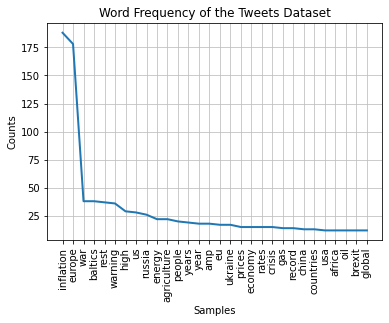

<AxesSubplot:title={'center':'Word Frequency of the Tweets Dataset'}, xlabel='Samples', ylabel='Counts'>

In [13]:
# display the frequency distribution
fdist = get_freq(tweets_df, 'tweet_clr')
fdist.plot(30, cumulative=False, title='Word Frequency of the Tweets Dataset')

#### Dataset Word Cloud

Another way to visualize text datasets is by using word clouds which facilitates the observation of the most frequent words.

It is evident the word 'inflation' is the most common in this dataset.

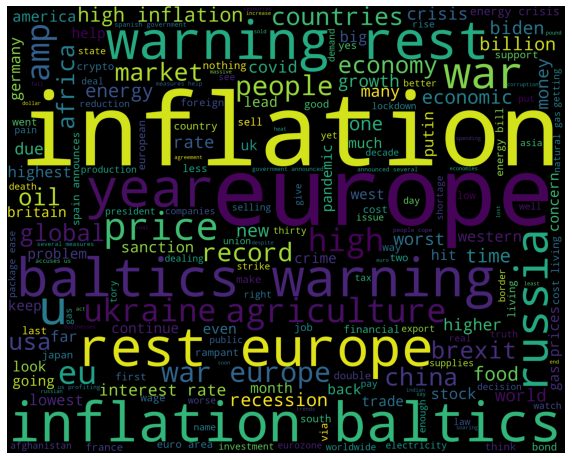

In [15]:
wordcloud_draw(tweets_df['tweet_clr'])

### Sentiment Classification

In this section, Naiva Bayes and Logistic Regression algorithms were tested against the tweets dataset to perform sentiment classification based on the tweets.

The question being solved is how to classify the sentiment of the tweets based on past data.

#### Naive Bayes

In this section, the Naive Bayes classifier is used on the tweets dataset.

Since every word can be treated as independent and makes equal contribution to the result, Naive Bayes technique can be used.

In order to apply the classifier, the texts were tokenized and a feature vector was extracted from each document (i.e., tweet).

From the data prepatation step, four versions of tweets were generated from the raw text: cleaned (keeping stop words), cleaned (no stop words), lemmatized and stemmerized tweets.

The classifier was executed over the different versions of tweets and two types of vectorizers: Tfidf and Count. The results obtained were compared.

The model was run with cross validation technique in which 10 folds were generated from the dataset. The average accuracy was calculated from each test execution.

Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})
Resampled dataset shape Counter({0: 73, 2: 73, 1: 73})
Resampled dataset shape Counter({1: 69, 2: 69, 0: 69})
Resampled dataset shape Counter({1: 69, 2: 69, 0: 69})
Resampled dataset shape Counter({2: 61, 0: 61, 1: 61})
Resampled dataset shape Counter({2: 61, 0: 61, 1: 61})
Resampled dataset shape Counter({2: 76, 0: 76, 1: 76})
Resampled dataset shape Counter({2: 76, 0: 76, 1: 76})
           CountVectorizer  TfidfVectorizer                tp_approach
tweet_clr         0.567143         0.682857    Cleaned (no stop words)
tweet_lm          0.570356         0.720553                 Lemmatizer
tweet_st          0.481287         0.525146                    Stemmer
tweet_str         0.639827         0.712771  Cleaned (with stop words)


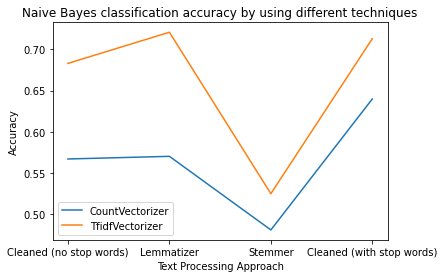

In [19]:
# setting the parameters for this experiment

# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# vectorizer names for readability
vt_names = ['TfidfVectorizer', 'CountVectorizer']
# vectorizer instances to be used
vt_inst = [TfidfVectorizer(max_features=5000), CountVectorizer(max_features=5000)]

# running Naive Bayes for each tweet column
results = {}
for i in range(0, len(X_names)):
    results[X_names[i]] = {}

    # trying different vectorizers
    for t in range(0, len(vt_inst)):
        vect = vt_inst[t]

        # getting X, y data to run the classifer
        X, y = get_X_y(tweets_df, X_names[i], y_names[i], vect)

        # data is not balanced, applying SMOTE technique to resample
        X, y = resample(X, y)

        # running the classifier with cross validation
        cf = run_naive_bayes_classifier_cross_val(X, y, 10)

        # running the classifier to get precision/recall report
        #print(run_naive_bayes_classifier(X, y))

        # storing the mean of the k folds tested
        results[X_names[i]][vt_names[t]] = cf.mean()

# convert results into dataframe
res_json = JsonHelper(results).to_string()
results_df = pd.read_json(res_json, orient ='index')

# mapping columns to the text processing approach used
tp_approach = {'tweet_str': 'Cleaned (with stop words)', 'tweet_clr': 'Cleaned (no stop words)', 'tweet_lm': 'Lemmatizer', 'tweet_st': 'Stemmer'}
results_df['tp_approach'] = results_df.index.to_series().map(tp_approach)

# plotting the accuracy of the classifier using different vectorizers and NLP
plt.title('Naive Bayes classification accuracy by using different techniques')
plt.plot(results_df['tp_approach'], results_df['CountVectorizer'], label='CountVectorizer')
plt.plot(results_df['tp_approach'], results_df['TfidfVectorizer'], label='TfidfVectorizer')
plt.ylabel('Accuracy')
plt.xlabel('Text Processing Approach')
plt.legend()

print(results_df)

Based on the results above, the Naive Bayes approach on the Lemmatized tweets using Tfidf Vectorizer provided better accuracy of about 72%.

The lowest accuracy obtained was about 48% by using Stemmer and Count Vectorizer on this dataset.

Stemmer approach produced the lowest accuracy on both vectorizer methods. 

Also, keeping the stop words produced better results than removing them in both cases.

#### Logistic Regression

In this experiment Logistc Regression classifier was applied. 

This algorithm was chosen due to its efficiency in predicting classes based on the features relationship.

GridSearchCV was applied in this test, which decided the best parameters to run the LR model on the tweets dataset.

The main parameters being tested were from the vectorizer strategy. which basically covered the use or not of stop words and the type of tokenizer.

Since the test involves deciding whether or not to use the stop words, the tweet_str column was used.

The SMOTE technique was also added to the pipeline to avoid noise given by unbalanced data.

The vectorizer applied in this test was the TfidfVectorizer because it was the approach that gave better results in the previous test.

In [18]:
# will use strip tweet with stop words to test the best words to remove
stop = stopwords.words('english')

# using the TfidfVectorizer tokenizer
vect = TfidfVectorizer(max_features=5000)

# setting up the pipeline steps: vectorize, smote and classification
lr = imbpipeline(steps = [['vect',  vect],
                          ['smote', SMOTE(random_state=11)],
                          ['clf',   LogisticRegression(random_state=42, max_iter=1000)]])

# testing vectorizer and classifier parameters
param_grid = [{'vect__stop_words': [stop, None],
               'vect__tokenizer': [TextProcessor.get_tokens, TextProcessor.apply_stemmer, TextProcessor.apply_lemmatizer],
               'vect__use_idf':[True, False],
               'vect__norm':[None, 'l1', 'l2'],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]}]

# using GridSearchCV to obtain the best parameters to test LR on tunned Tfidf vectorizer
gs_lr = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)

# getting test and training set
X, y = get_X_y(tweets_df, 'tweet_str', 'sent_str')

# getting training test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# running param tunning on train data
gs_lr.fit(X_train, y_train)

# getting the results
clf = gs_lr.best_estimator_

print(f'Using { vt_names[0] }')
print('Best parameter set: %s ' % gs_lr.best_params_)
print('CV Accuracy: %.3f' % gs_lr.best_score_)
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Using TfidfVectorizer
Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__norm': 'l2', 'vect__stop_words': None, 'vect__tokenizer': <function TextProcessor.apply_stemmer at 0x0000021BD275C940>, 'vect__use_idf': True} 
CV Accuracy: 0.549
Test Accuracy: 0.481


Logistic Regression provided poorer results compared to the Naive Bayes approach. Its accuracy with the parameters given by GridSearchCV was just 55%.

Interesting to note that the result from GridSearchCV was given by using stop words and Stemmer technique, which differs from the approach that gave better results in the previous experiment.

## Crops and livestock import/export prediction

In this part, the crops and livestock dataset was analyzed using ML technniques to make predictions about the import/export of products in Ireland and other EU countries.

The base question explored in this analysis was: What is the import/export forecast in Ireland as compared with other countries in the EU for the next years?

In the first part of the analysis, the average import/export quantity dataset is used against the ML models.

In the second part, specific products were analyzed, more specifically the top 10 most imported products in Ireland.


Run models

Cross-validate

Gridvc

accuracy

2 models

compare results

### Data Preparation and Visualization

In [21]:
# showing raw dataset
dataset = pd.read_csv('./datasets/fao-import-export-eu.csv', encoding='utf-8')
dataset.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1961,1961,tonnes,95.0,A,Official figure
1,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1962,1962,tonnes,32.0,A,Official figure
2,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1963,1963,tonnes,115.0,A,Official figure
3,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1964,1964,tonnes,49.0,A,Official figure
4,TCL,Crops and livestock products,246,Finland,5610,Import Quantity,01929.07,"Abaca, manila hemp, raw",1965,1965,tonnes,42.0,A,Official figure


In [32]:
# convert value into numeric type
dataset['Value'] = dataset['Value'].apply(lambda x : pd.to_numeric(x, errors='coerce'))

In [24]:
# splitting data into import/export value and quantity
im_ex_val_data = dataset[(dataset['Element'].isin(['Import Value', 'Export Value']))]
im_ex_qtt_data = dataset[(dataset['Element'].isin(['Import Quantity', 'Export Quantity']))]

In [28]:
# checking unit for import/export quantity data
print(im_ex_val_data['Unit'].unique())
print(im_ex_qtt_data['Unit'].unique())

['1000 US$']
['tonnes' 'Head' 'No' '1000 Head']


In [30]:
im_ex_qtt_data['Unit'].describe()

count      94961
unique         1
top       tonnes
freq       94961
Name: Unit, dtype: object

In [29]:
# since tonnes is the most frequent unit, remove the other ones
im_ex_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Unit'] == 'tonnes']
im_ex_qtt_data.shape

(94961, 14)

In [31]:
# getting import data only (quantity and value)
import_qtt_data = im_ex_qtt_data[im_ex_qtt_data['Element'] == 'Import Quantity']
import_val_data = im_ex_val_data[im_ex_val_data['Element'] == 'Import Value']

# getting the top 10 import items in terms of quantity in Ireland
top_10_items_ire = import_qtt_data[(import_qtt_data['Area'] == 'Ireland')].groupby(by='Item', as_index=False).mean().sort_values(by=['Value'], ascending=False, ignore_index=True).head(10)
top_10_items_ire = list(top_10_items_ire['Item'].unique())

print('Top 10 most imported products in Ireland:')
top_10_items_ire

Top 10 most imported products in Ireland:


['Maize (corn)',
 'Wheat',
 'Cake of  soya beans',
 'Food wastes',
 'Molasses',
 'Raw milk of cattle',
 'Brewing or distilling dregs and waste',
 'Other non-alcoholic caloric beverages',
 'Bran of wheat',
 'Gluten feed and meal']

In [ ]:
degrees = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
lr_results_vehicle = []
for v in to_model:
    # splitting data into train and test data for each vehicle
    X_train, y_train, X_test, y_test = splitTrainTest(df_scaler, 'Time_Index', v)

    # prediction results for test and training datasets
    y_train_pred = np.zeros((len(X_train), len(degrees)))
    y_test_pred = np.zeros((len(X_test), len(degrees)))

    # trying linear regression with different degrees
    for i in range(0, len(degrees)):
        y_train_pred_i, y_test_pred_i = linearRegression(X_train, y_train, X_test, degrees[i])
        y_train_pred[:, i] = y_train_pred_i
        y_test_pred[:, i]  = y_test_pred_i
    
    # plotting train data
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.scatter(X_train, y_train)
    plt.yscale('log')
    plt.title(f'Train data for {v}')
    for i, degree in enumerate(degrees):    
        plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
        plt.legend(loc='upper left')

    # plotting test data
    plt.subplot(122)
    plt.scatter(X_test, y_test)
    plt.yscale('log')
    plt.title(f'Test data for {v}')
    for i, degree in enumerate(degrees):    
        plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
        plt.legend(loc='upper left')

    # generate the validation results per degree with r2 score
    for i, degree in enumerate(degrees):
        train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
        test_r2 = round(sklearn.metrics.r2_score(y_test, y_test_pred[:, i]), 2)
        lr_results_vehicle.append([v, degree, train_r2, test_r2])